### Import necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sn
import datetime
import time

# Songs and song feature extraction APIs
import billboard
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

# Pre-processing 
from sklearn.preprocessing import StandardScaler, MinMaxScaler, scale

# Splitting Data into Train and Test
from sklearn.model_selection import train_test_split

# Models
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegressionCV
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgboost
from xgboost import XGBClassifier

# Evaluation Metrics
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score

# Save / Load models
import joblib

import os
import warnings
warnings.filterwarnings("ignore")

### Collect Songs from Billboard for the given time range of 20 years

In [ ]:
num_years = 2
for year in ["%.2d" % i for i in range(19-num_years+1, 19)]:
    prev_date_list = []
    date1 = '20'+year+'-01-01'
    date2 = '20'+str(int(year)+1)+'-11-30'
    start = datetime.datetime.strptime(date1, '%Y-%m-%d')
    end = datetime.datetime.strptime(date2, '%Y-%m-%d')
    step = datetime.timedelta(days=60)
    while start <= end:
        prev_date_list.append(str(start.date()))
        start += step
    print(prev_date_list)

    cols = ['Artist','Track','Label']
    billboard_df = pd.DataFrame()
    chart = billboard.ChartData('hot-100', prev_date_list[0])
    for i in range(1, len(prev_date_list)):
        for ind in range(1, len(chart))[:30]:
            song = chart[ind]
            if i != 1 and song.title in billboard_df[1]:
                pass
            else:
                entry = []
                entry.extend((song.artist, song.title, str(1)))
                billboard_df = billboard_df.append(pd.DataFrame(entry).T)
        chart = billboard.ChartData('hot-100', prev_date_list[i])
        time.sleep(1)
billboard_df.to_csv("billboard_data.csv", index=False)

### Collect Songs which did not make it to the Billboard for the given time range of 20 years

In [ ]:
billboard_df = pd.read_csv("billboard_data.csv", names=cols).iloc[1:,:]
chart = billboard.ChartData('radio-songs', prev_date_list[0])
for i in range(1, len(prev_date_list)):
    for ind in range(1, len(chart))[:30]:
        song = chart[ind]
        if i != 1 and song.title in billboard_df.iloc[:,1]:
            pass
        else:
            entry = []
            entry.extend((song.artist, song.title, str(0)))
            billboard_df = billboard_df.append(pd.DataFrame(entry, index=cols).T)
    chart = billboard.ChartData('radio-songs', prev_date_list[i])
    time.sleep(2)
billboard_df.to_csv("billboard_data.csv", index=False)

### Extract Song features from Spotify and construct the dataset

In [ ]:
billboard_df = pd.read_csv("billboard_data.csv")
client_credentials_manager = SpotifyClientCredentials(client_id="769ef3519e8444238fde9c8981c6371c",\
                                                      client_secret="b17e4a7ca0b4426f9962645ba5c74a63")
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
features_df = pd.DataFrame()
time_df = pd.DataFrame()
release_feat = ['Year','Month']
spotify_feat = ['Danceability','Energy','Key','Loudness','Mode','Speechiness',\
                'Acousticness','Instrumentalness','Liveness','Valence','Tempo']
for ind in range(len(billboard_df.iloc[:,0:2])):
    artist, track = billboard_df.iloc[ind,0:2]
    songs=sp.search(q='track:'+track+' '+'artist:'+artist+'*' , type='track')
    items = songs['tracks']['items']
    features_to_df = []
    if len(items) == 0:
        features_df = features_df.append(pd.Series(['None']*18), ignore_index = True)
        time_df = time_df.append(pd.Series(['None']*2), ignore_index = True)
    else:
        track = items[0]
        song_id = str(track["id"])
        track_features=sp.audio_features(song_id)
        if int(track['album']['release_date'].split('-')[0]) < 2000: 
            y = 'None'
            m = 'None'
        else:
            y = track['album']['release_date'].split('-')[0]
            m = track['album']['release_date'].split('-')[1]
        rel = [y,m]
        time_df = time_df.append(pd.DataFrame(rel).T)
        features_to_df = [val for val in (track_features)[0].values()]
        features_df = features_df.append(pd.DataFrame(features_to_df).T)
features_df = features_df.drop([11, 12, 13, 14, 15, 16, 17], axis=1)
features_df.columns = spotify_feat
time_df.columns = release_feat
output = pd.concat([billboard_df.iloc[:-1,:],features_df.iloc[:-1,:],time_df.iloc[:-1,:]],axis=1)
output.to_csv("billboard_data_with_spotify.csv", index = False)

### Load and split data into Training, Test and Validation sets

In [2]:
dataset = pd.read_csv('billboard_data_with_spotify.csv').drop(['Artist','Track'], axis = 1)
colnames = list(dataset.columns)
dataset_no_label = dataset.drop(['Label'], axis = 1)
dataset['Label'] = pd.to_numeric(dataset['Label'])
data_train, data_sec = train_test_split(dataset, test_size = 0.1, random_state=5)
data_val, data_test = train_test_split(data_sec, test_size = 0.5, random_state=5)
scaler = MinMaxScaler()
data_train[data_train.columns[:2]] = scaler.fit_transform(data_train[data_train.columns[:2]])
data_val[data_val.columns[:2]] = scaler.transform(data_val[data_val.columns[:2]])
data_test[data_test.columns[:2]] = scaler.transform(data_test[data_test.columns[:2]])
data_train[data_train.columns[3:4]] = scaler.fit_transform(data_train[data_train.columns[3:4]])
data_val[data_val.columns[3:4]] = scaler.transform(data_val[data_val.columns[3:4]])
data_test[data_test.columns[3:4]] = scaler.transform(data_test[data_test.columns[3:4]])
data_train[data_train.columns[5:len(data_train.columns)-3]] = scaler.fit_transform(data_train[data_train.columns[5:len(data_train.columns)-3]])
data_val[data_val.columns[5:len(data_val.columns)-3]] = scaler.transform(data_val[data_val.columns[5:len(data_val.columns)-3]])
data_test[data_test.columns[5:len(data_test.columns)-3]] = scaler.transform(data_test[data_test.columns[5:len(data_test.columns)-3]])
data_train.to_csv('data/data_hit_training.csv', index = False)
data_val.to_csv('data/data_hit_validation.csv', index = False)
data_test.to_csv('data/data_hit_test.csv', index = False)

In [6]:
pd.DataFrame(dataset['Label'].value_counts())

,Label
0,2002
1,1437


In [3]:
data_train = pd.read_csv('../data/data_hit_training.csv')
data_val = pd.read_csv('../data/data_hit_validation.csv')
data_test = pd.read_csv('../data/data_hit_test.csv')
ytrain, xtrain = data_train['Label'], data_train.iloc[:,:-1]
yval, xval = data_val['Label'], data_val.iloc[:,:-1]
ytest, xtest = data_test['Label'], data_test.iloc[:,:-1]

### Visualize the datapoints

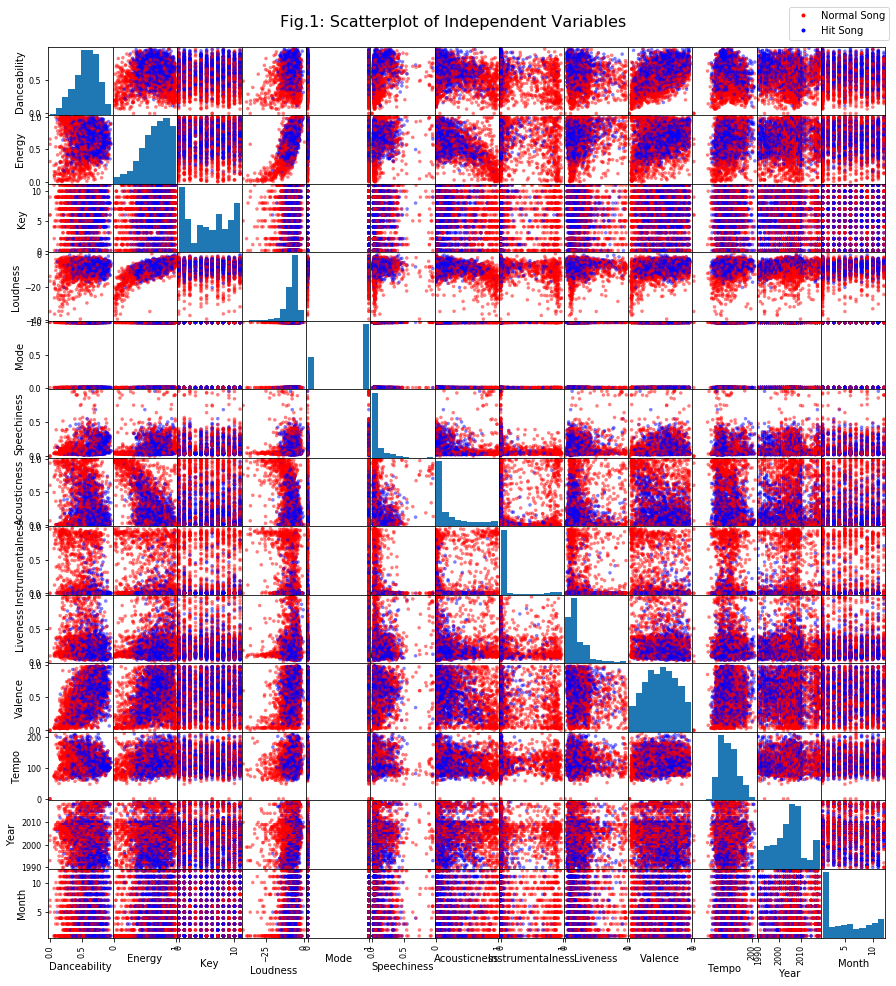

In [259]:
color = []
for i in dataset['Label']:
    if i == 1:
        color.append('blue')
    else:
        color.append('red')
# Used Pandas to plot the scatter plot of the independent variables
pd.plotting.scatter_matrix(dataset_no_label,figsize=(15,15),marker='.',c=color,alpha=0.5,s=50)
plt.subplots_adjust(top=0.95)
plt.suptitle('Fig.1: Scatterplot of Independent Variables', fontsize=16)
# Extra commands to display legend
c0, = plt.plot([1,1],'r.')
c1, = plt.plot([1,1],'b.')
plt.legend((c0, c1),('Normal Song', 'Hit Song'),loc=(-0.5,13.1))
c0.set_visible(False)
c1.set_visible(False)
plt.savefig('conf_matrices/hit_pred_scatter_matrix.jpg')

In [225]:
os.system('rm -rf models/')
os.system('mkdir models/')

0

### K Nearest Neighbors

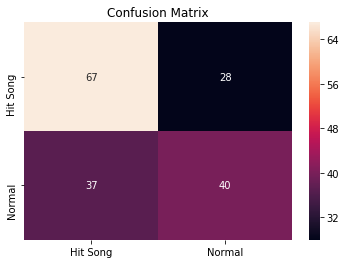


Precision:  0.588
Recall:  0.519
F1-Score:  0.552
Accuracy:  0.622


In [9]:
err_test = []
step_k = 1
k = range(1, 50, step_k)
for i in k:
    knn = KNeighborsClassifier(n_neighbors=i,p=1)        
    knn.fit(xtrain, ytrain)            
    predict_train = knn.predict(xtrain)       
    predict_test = knn.predict(xval)         
    err_test.append(np.mean(predict_test != yval))     

k_opt = 1 + step_k * err_test.index(np.min(err_test))    
plt.figure(figsize = (10, 5))  
plt.plot(k, err_test, color = 'red', label = 'Test Error')
plt.title('Fig.2: Error Rate vs K-Value',fontsize = 15) 
plt.xlabel('K Value')  
plt.ylabel('Error Points')  
plt.legend()

knn = KNeighborsClassifier(n_neighbors = k_opt, p = 1)   
knn.fit(xtrain, ytrain)
joblib.dump(knn,'models/knn_hit_trained.pkl')

predict_test = knn.predict(xval)
predict_test = predict_test[:,np.newaxis]
mat = confusion_matrix(yval, predict_test)
temp = pd.DataFrame(mat, index=['Hit Song','Normal'], columns=['Hit Song','Normal'])
fig = plt.figure()
sn.heatmap(temp, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.show()
fig.savefig('conf_matrices/hit_knn_cm.jpg')

print('\nPrecision: ',round(precision_score(yval,predict_test,average = None)[1],3))
print('Recall: ',round(recall_score(yval,predict_test,average = None)[1],3))
print('F1-Score: ',round(f1_score(yval,predict_test,average=None)[1],3))
print('Accuracy: ',round(accuracy_score(yval,predict_test),3))

### Logistic Regression

Optimal Number of Estimators to be used: 10


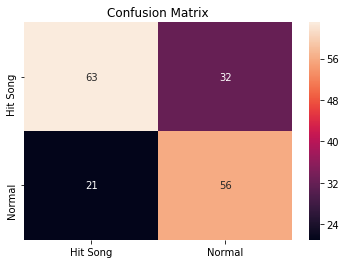


Precision:  0.636
Recall:  0.727
F1-Score:  0.679
Accuracy:  0.692


In [265]:
c_est = range(10, 50, 10)
acc_test = []
for i in c_est:
    lregcv = LogisticRegressionCV(cv=i, solver = 'liblinear', penalty = 'l1',refit=True).fit(xtrain, ytrain)
    lreg_pred_test = lregcv.predict(xval)
    acc_test.append(accuracy_score(yval,lreg_pred_test))
c_est_opt = 10 * (acc_test.index(np.max(acc_test))+1)
print('Optimal Number of Estimators to be used:', c_est_opt)

lreg = LogisticRegressionCV(cv = c_est_opt, solver = 'liblinear', penalty = 'l1',refit=True)
lreg.fit(xtrain,ytrain)
joblib.dump(lreg, 'models/logreg_hit_trained.pkl')
pred_lreg = lreg.predict(xval)
mat = confusion_matrix(yval, pred_lreg)
temp = pd.DataFrame(mat, index=['Hit Song','Normal'], columns=['Hit Song','Normal'])
fig = plt.figure()
sn.heatmap(temp, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.show()
fig.savefig('conf_matrices/hit_logreg_cm.jpg')
print('\nPrecision: ',round(precision_score(yval,pred_lreg,average = None)[1],3))
print('Recall: ',round(recall_score(yval,pred_lreg,average = None)[1],3))
print('F1-Score: ',round(f1_score(yval,pred_lreg,average=None)[1],3))
print('Accuracy: ',round(accuracy_score(yval,pred_lreg),3))

### Support Vector Machine

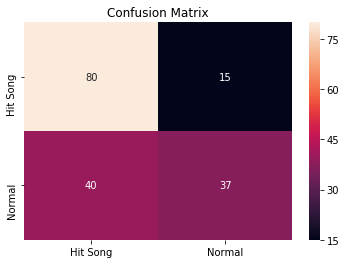


Precision:  0.712
Recall:  0.481
F1-Score:  0.574
Accuracy:  0.68


In [249]:
C_est = range(1, 101, 5)
acc_test = []
for i in C_est:
    svc = SVC(C = i, probability = True, class_weight=dict(ytrain.value_counts(normalize = True)))
    svc.fit(xtrain, ytrain)
    svc_pred_test = svc.predict(xval)
    acc_test.append(accuracy_score(yval,svc_pred_test))
C_est_opt = 5 * acc_test.index(np.max(acc_test))

svc = SVC(C = C_est_opt, probability = True, class_weight=dict(ytrain.value_counts(normalize = True)))
svc.fit(xtrain, ytrain)
joblib.dump(svc,'models/svm_hit_trained.pkl')
svm_pred = svc.predict(xval)
mat = confusion_matrix(yval, svm_pred)
temp = pd.DataFrame(mat, index=['Hit Song','Normal'], columns=['Hit Song','Normal'])
fig = plt.figure()
sn.heatmap(temp, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.show()
fig.savefig('conf_matrices/hit_svm_cm.jpg')
print('\nPrecision: ',round(precision_score(yval,svm_pred,average = None)[1],3))
print('Recall: ',round(recall_score(yval,svm_pred,average = None)[1],3))
print('F1-Score: ',round(f1_score(yval,svm_pred,average=None)[1],3))
print('Accuracy: ',round(accuracy_score(yval,svm_pred),3))

### Random Forest

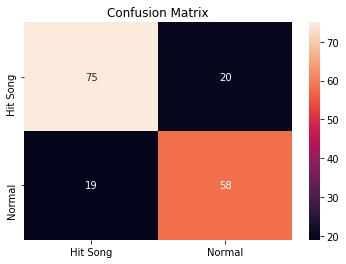


Precision:  0.744
Recall:  0.753
F1-Score:  0.748
Accuracy:  0.773


In [250]:
N_est = range(100, 1001, 25)
acc_test = []
for i in N_est:
    rf = RandomForestClassifier(n_estimators=i, min_samples_split=10)
    rf.fit(xtrain,ytrain)
    rf_pred_test = rf.predict(xval)
    acc_test.append(accuracy_score(yval,rf_pred_test))

N_est_opt = 100 + (25 * acc_test.index(np.max(acc_test)))

rf = RandomForestClassifier(n_estimators=N_est_opt, min_samples_split=10)
rf.fit(xtrain, ytrain)
joblib.dump(rf, 'models/random_forest_hit_trained.pkl')
rf_pred = rf.predict(xval) 
mat = confusion_matrix(yval, rf_pred)
temp = pd.DataFrame(mat, index=['Hit Song','Normal'], columns=['Hit Song','Normal'])
fig = plt.figure()
sn.heatmap(temp, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.show()
fig.savefig('conf_matrices/hit_random_forest_cm.jpg')
print('\nPrecision: ',round(precision_score(yval,rf_pred,average = None)[1],3))
print('Recall: ',round(recall_score(yval,rf_pred,average = None)[1],3))
print('F1-Score: ',round(f1_score(yval,rf_pred,average=None)[1],3))
print('Accuracy: ',round(accuracy_score(yval,rf_pred),3))

### XGBoost

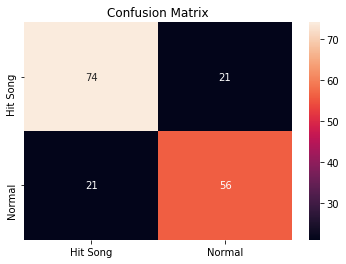


Precision:  0.727
Recall:  0.727
F1-Score:  0.727
Accuracy:  0.756


In [251]:
N_est = range(100, 1001, 100)
acc_test = []
for i in N_est:
    boost = XGBClassifier(n_estimators=i, max_depth=10, subsample=0.9, num_class = 2, objective='multi:softmax')
    boost.fit(xtrain, ytrain)
    boost_pred_test = boost.predict(xval)
    acc_test.append(accuracy_score(yval,boost_pred_test))
N_est_opt = 100 * (acc_test.index(np.max(acc_test))-1)

boost = XGBClassifier(n_estimators=N_est_opt, max_depth=10, subsample=0.9, num_class = 2, objective='multi:softmax')
boost.fit(xtrain, ytrain)
joblib.dump(boost, 'models/xgboost_hit_trained.pkl')
boost_pred = boost.predict(xval)
mat = confusion_matrix(yval, boost_pred)
temp = pd.DataFrame(mat, index=['Hit Song','Normal'], columns=['Hit Song','Normal'])
fig = plt.figure()
sn.heatmap(temp, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.show()
fig.savefig('conf_matrices/hit_xgboost_cm.jpg')
print('\nPrecision: ',round(precision_score(yval,boost_pred,average = None)[1],3))
print('Recall: ',round(recall_score(yval,boost_pred,average = None)[1],3))
print('F1-Score: ',round(f1_score(yval,boost_pred,average=None)[1],3))
print('Accuracy: ',round(accuracy_score(yval,boost_pred),3))

In [266]:
model_accuracy = []
model_accuracy.append(round(accuracy_score(yval,predict_test),3))
model_accuracy.append(round(accuracy_score(yval,pred_lreg),3))
model_accuracy.append(round(accuracy_score(yval,svm_pred),3))
model_accuracy.append(round(accuracy_score(yval,rf_pred),3))
model_accuracy.append(round(accuracy_score(yval,boost_pred),3))

model_fscore = []
model_fscore.append(round(f1_score(yval,predict_test,average = None)[1],3))
model_fscore.append(round(f1_score(yval,pred_lreg,average = None)[1],3))
model_fscore.append(round(f1_score(yval,svm_pred,average = None)[1],3))
model_fscore.append(round(f1_score(yval,rf_pred,average = None)[1],3))
model_fscore.append(round(f1_score(yval,boost_pred,average = None)[1],3))

model_precision = []
model_precision.append(round(precision_score(yval,predict_test,average = None)[1],3))
model_precision.append(round(precision_score(yval,pred_lreg,average = None)[1],3))
model_precision.append(round(precision_score(yval,svm_pred,average = None)[1],3))
model_precision.append(round(precision_score(yval,rf_pred,average = None)[1],3))
model_precision.append(round(precision_score(yval,boost_pred,average = None)[1],3))

model_recall = []
model_recall.append(round(recall_score(yval,predict_test,average = None)[1],3))
model_recall.append(round(recall_score(yval,pred_lreg,average = None)[1],3))
model_recall.append(round(recall_score(yval,svm_pred,average = None)[1],3))
model_recall.append(round(recall_score(yval,rf_pred,average = None)[1],3))
model_recall.append(round(recall_score(yval,boost_pred,average = None)[1],3))

res_list = []
res_list.append(model_accuracy)
res_list.append(model_fscore)
res_list.append(model_precision)
res_list.append(model_recall)

eval_metrics_hit = ['Accuracy','F-Score','Precision','Recall']
models_to_test_hit = ['K-Nearest Neighbors','Logistic Regression','Support Vector Machine','Random Forest','XGBoost']
metrics_hit = pd.DataFrame(res_list, columns=models_to_test_hit, index=eval_metrics_hit)
metrics_hit

,K-Nearest Neighbors,Logistic Regression,Support Vector Machine,Random Forest,XGBoost
Accuracy,0.622,0.692,0.680,0.773,0.756
F-Score,0.552,0.679,0.574,0.748,0.727
Precision,0.588,0.636,0.712,0.744,0.727
Recall,0.519,0.727,0.481,0.753,0.727


In [273]:
metrics_hit.index.name = 'Metric'
metrics_hit.to_csv('eval_metrics_training.csv', mode='a')

### Test the best models on the Test Data

In [267]:
best_model1 = joblib.load('models/random_forest_hit_trained.pkl')
pred_best_model1 = best_model1.predict(xtest)
print('Hit Prediction using Random Forest Model Accuracy: ',round(accuracy_score(ytest,pred_best_model1),3))
best_model2 = joblib.load('models/xgboost_hit_trained.pkl')
pred_best_model2 = best_model2.predict(xtest)
print('\nHit Prediction using Gradient Boosting Tree Model Accuracy: ',round(accuracy_score(ytest,pred_best_model2),3))

Hit Prediction using Random Forest Model Accuracy:  0.727

Hit Prediction using Gradient Boosting Tree Model Accuracy:  0.715
